In [1]:
# Step 1: create the database (if not created already)

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import json
import pandas as pd


# Preliminary setup: create database(s), unless they're already there
# Define a database name 
# Set your postgres username
dbname = 'Yelp'
username = 'brooks' # change this to your username

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))



postgres://brooks@localhost/Yelp
True


In [1]:
# Make a checker to see if a table exists already
def checkTableExists(dbcon, tablename):
    dbcur = dbcon.cursor()
    dbcur.execute("""
        SELECT COUNT(*)
        FROM information_schema.tables
        WHERE table_name = '{0}'
        """.format(tablename.replace('\'', '\'\'')))
    if dbcur.fetchone()[0] == 1:
        dbcur.close()
        return True

    dbcur.close()
    return False

In [ ]:
# Initial database import


# Import relevant fields from all businesses
conn = psycopg2.connect(database='Yelp', user='brooks', password='davidson', host='localhost')
if checkTableExists(conn,'t_businesses')!=True:
    # Read JSON data & create table for businesses (one column per field)
    print("Importing businesses...")
    data = load_json('./yelp_data/yelp_academic_dataset_business.json')
    cur = conn.cursor()
    cur.execute(
    """CREATE TABLE t_businesses (business_id VARCHAR, name VARCHAR, 
        address VARCHAR, city VARCHAR, latitude FLOAT, longitude FLOAT, stars FLOAT, categories VARCHAR);"""
    )
    fields = [
        'business_id',
        'name',
        'address',
        'city',
        'latitude',
        'longitude',
        'stars',
        'categories'
    ]
    for item in data:
        my_data = [item[field] for field in fields]
        # need a placeholder (%s) for each variable 
        # refer to postgres docs on INSERT statement on how to specify order
        cur.execute("INSERT INTO t_businesses VALUES (%s, %s, %s, %s, %s, %s, %s, %s)", tuple(my_data))
    print("done.")
else:
    print('Businesses already imported')


# Import all reviews
if checkTableExists(conn,'t_reviews')!=True:
    # Read JSON data & create table for businesses (one column per field)
    print("Importing reviews...")
    data = load_json('./yelp_data/yelp_academic_dataset_review.json')
    cur = conn.cursor()
    cur.execute(
    """CREATE TABLE t_reviews (user_id VARCHAR, business_id VARCHAR, stars INT,
        date DATE, text TEXT, useful INT);"""
    )
    fields = [
        'user_id',
        'business_id',
        'stars',
        'date',
        'text',
        'useful',
    ]
    for item in data:
        my_data = [item[field] for field in fields]
        # need a placeholder (%s) for each variable 
        # refer to postgres docs on INSERT statement on how to specify order
        cur.execute("INSERT INTO t_reviews VALUES (%s, %s, %s, %s, %s, %s)", tuple(my_data))
    print("done.")
else:
    print('Reviews already imported')

       

# commit changes & close.
conn.commit()
conn.close()



Businesses already imported
Reviews already imported
Collating reviews...


In [2]:
# Show some key aspects of this dataset - what business & review entries look like,
# as well as the full list of all locations
import psycopg2
import pandas as pd
import numpy as np 
from IPython.display import display, HTML

conn = psycopg2.connect(database='Yelp', user='brooks', password='davidson', host='localhost')

# 1) Pull the business table into a dataframe - see a few examples
sql_query = """
SELECT * FROM t_businesses;
"""
buis_from_sql = pd.read_sql_query(sql_query,conn)
print('Businesses:')
display(buis_from_sql.head(5))

# 2) Show an example of reviews from some business
sql_query = """
SELECT * FROM t_reviews WHERE business_id='bFzdJJ3wp3PZssNEsyU23g';
"""
reviews_from_sql = pd.read_sql_query(sql_query,conn)
print('Example Reviews:') 
display(reviews_from_sql.head(5))

# 3) Show ALL cities in the database
pd.set_option('display.max_rows', 1200)
sql_query = """
SELECT * FROM t_businesses;
"""
buis_from_sql = pd.read_sql_query(sql_query,conn)
print('All cities in dataset:')
display(pd.Series(np.sort(buis_from_sql['city'].unique())))

conn.close()


Businesses:


,business_id,name,address,city,latitude,longitude,stars,categories
0,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,1314 44 Avenue NE,Calgary,51.091813,-114.031675,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho..."
1,AjEbIBw6ZFfln7ePHha9PA,CK'S BBQ & Catering,,Henderson,35.960734,-114.939821,4.5,"Chicken Wings, Burgers, Caterers, Street Vendo..."
2,O8S5hYJ1SMc8fA4QBtVujA,La Bastringue,1335 rue Beaubien E,Montréal,45.540503,-73.599300,4.0,"Breakfast & Brunch, Restaurants, French, Sandw..."
3,bFzdJJ3wp3PZssNEsyU23g,Geico Insurance,211 W Monroe St,Phoenix,33.449999,-112.076979,1.5,"Insurance, Financial Services"
4,8USyCYqpScwiNEb58Bt6CA,Action Engine,2005 Alyth Place SE,Calgary,51.035591,-114.027366,2.0,"Home & Garden, Nurseries & Gardening, Shopping..."


Example Reviews:


,user_id,business_id,stars,date,text,useful
0,QKYH1FUlRRVD-qXfUxS13A,bFzdJJ3wp3PZssNEsyU23g,1,2017-01-30,GEICO for auto is great! But they are really r...,0
1,54aYSgDy5bVobEyWbbyE_g,bFzdJJ3wp3PZssNEsyU23g,1,2018-06-28,So disappointed in this greedy company. They r...,0
2,nwDS6tgA4_HZ7mtyxzX1Ug,bFzdJJ3wp3PZssNEsyU23g,1,2018-06-28,Held my family hostage for over two years as a...,0
3,KeUFQ3T8tCZatAezFf-zsw,bFzdJJ3wp3PZssNEsyU23g,1,2017-12-11,This review has nothing to do with the locatio...,0
4,ZoPuRzKseZY39lkVoK_J5g,bFzdJJ3wp3PZssNEsyU23g,1,2015-08-18,Geico is my insurance and I had a wreck. I too...,1


All cities in dataset:


0                                                        
1                                           110 Las Vegas
2                                               AGINCOURT
3                                               Agincourt
4                                              Ahwahtukee
5                                               Ahwatukee
6                             Ahwatukee Foothills Village
7                                                 Airdrie
8                                                    Ajax
9                                 Alberta Park Industrial
10                                                 Alburg
11                                                Alburgh
12                                              Allegheny
13                                           Allison Park
14                                               Ambridge
15                                                Amherst
16                                           Ange-Gardien
17            

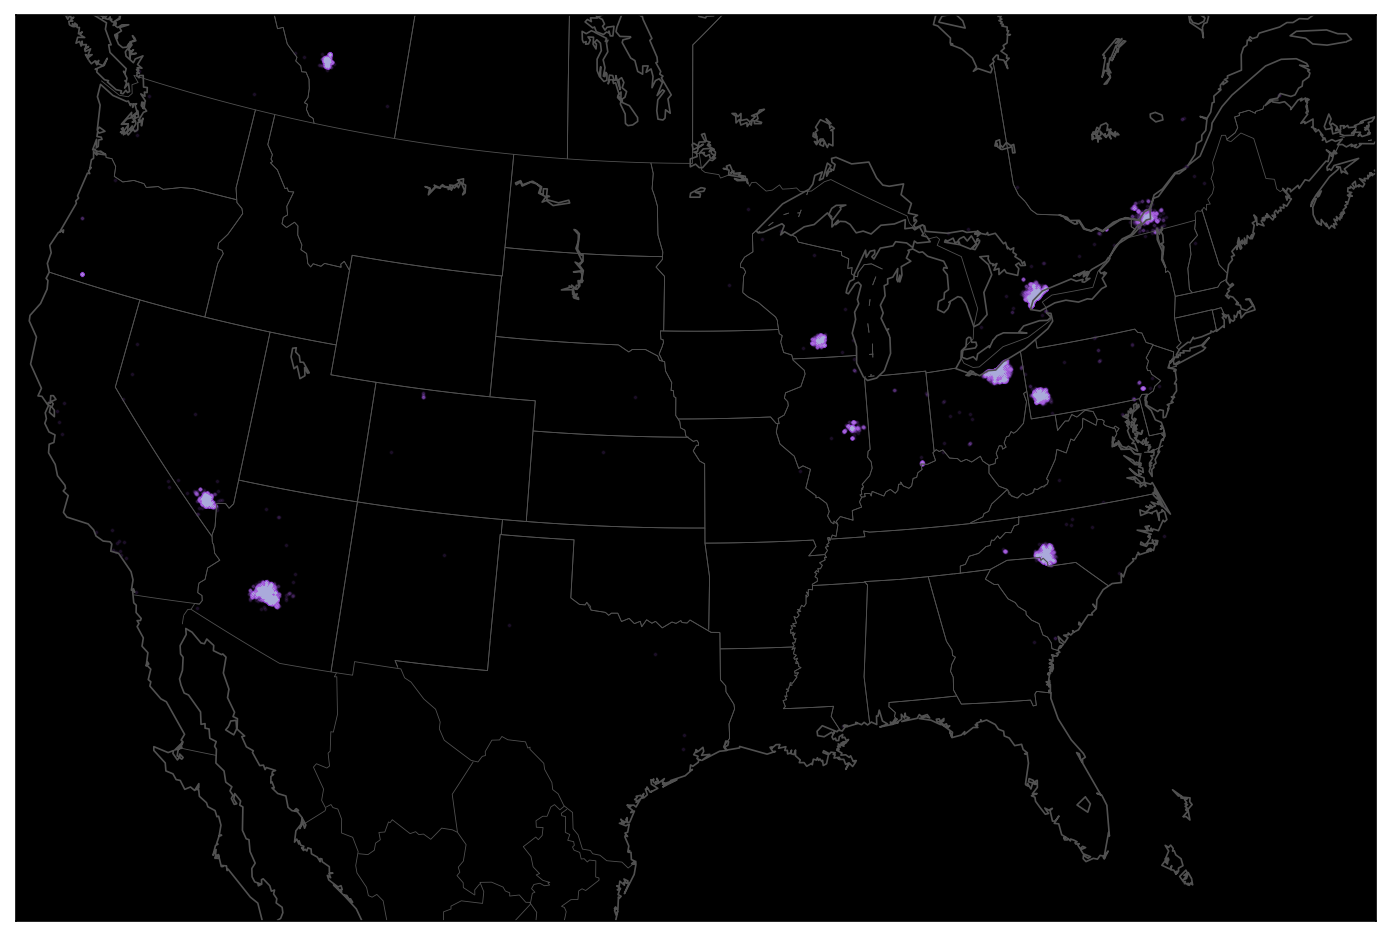

In [8]:
# Make a map showing all locations we have in the database
import numpy as np
import matplotlib.pyplot as plt

# Required lines to get stupid basemap working with this stupid kernel
import os
import conda
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap


# Extract the data we're interested in
lat = buis_from_sql['latitude'].values
lon = buis_from_sql['longitude'].values


# 1. Draw the map background
fig = plt.figure(figsize=(15, 10),dpi=120)
m = Basemap(projection='lcc', resolution='l', 
            lat_0=39, lon_0=-95,
            width=5E6, height=3.33E6)
m.drawmapboundary(fill_color='black')
m.drawcoastlines(color='#515151')
m.drawcountries(color='#515151')
m.drawstates(color='#515151')

# 2. Show businesses as beautiful purple fireflies
m.scatter(lon, lat, 2, '#A358E4', latlon=True, alpha=0.1)
m.scatter(lon, lat, 0.02, '#FFFFFF', latlon=True, alpha=0.05)



In [3]:
# Restrict our dataset to businesses in/around one location:
# Phoenix, AZ: 33.4484° N, 112.0740° W
conn = psycopg2.connect(database='Yelp', user='brooks', password='davidson', host='localhost')

# Count total businesses within a 100-mile radius of PHX
radius = (100 / 69); # in miles, converted to degrees lat/long
start_lat = 33.4484
start_long = -112.0740
sql_query = f"""
SELECT * FROM t_businesses WHERE (((latitude - {start_lat}) * (latitude - {start_lat})) + 
((longitude - {start_long}) * (longitude - {start_long}))) < {np.power(radius,2)};
"""
nearby_stores = pd.read_sql_query(sql_query,conn)
print("Number of businesses found within", radius*69, "mile radius of address:", nearby_stores.shape[0])

if checkTableExists(conn,'t_phoenix')!=True:
    cur = conn.cursor()
    cur.execute( f"""
    CREATE TABLE t_phoenix AS (SELECT * FROM t_businesses WHERE (((latitude - {start_lat}) * (latitude - {start_lat})) + 
    ((longitude - {start_long}) * (longitude - {start_long}))) < {np.power(radius,2)});
    """);
    conn.commit()
else:
    print('PHX subset exists as t_phoenix')
conn.close()



Number of businesses found within 100.0 mile radius of address: 56472
PHX subset exists as t_phoenix


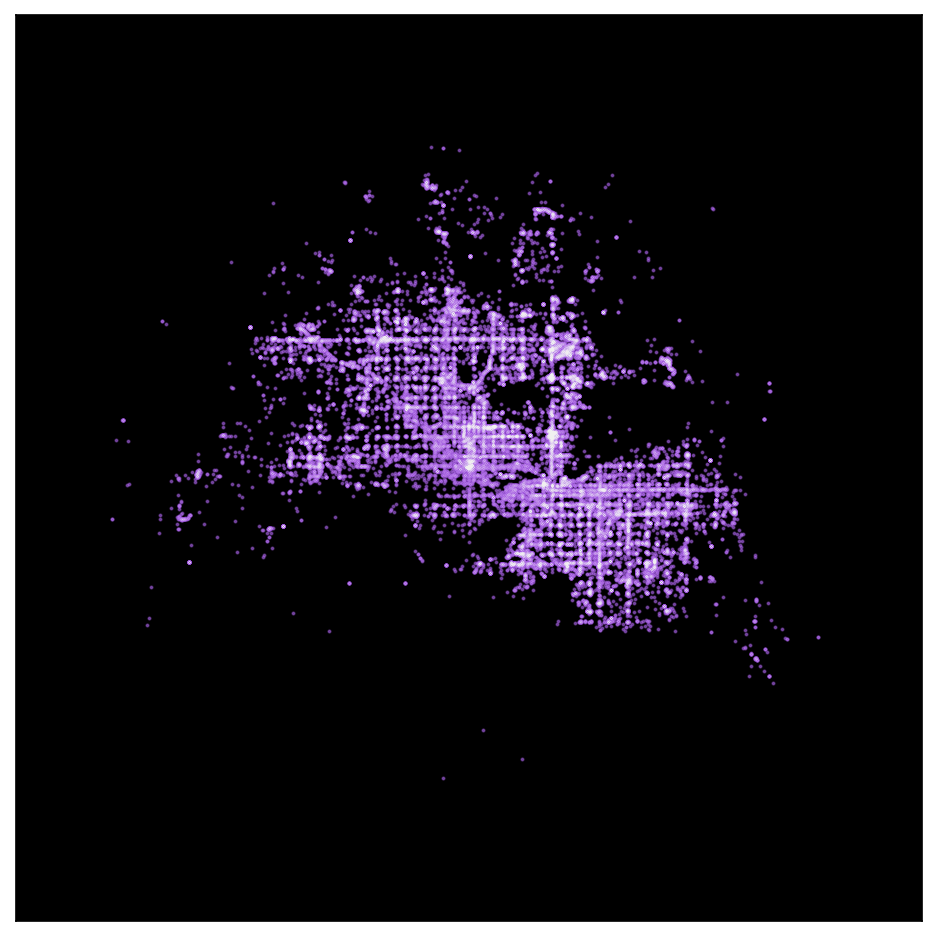

In [16]:
# Make a map showing all locations we have in the database

# Extract the data we're interested in
conn = psycopg2.connect(database='Yelp', user='brooks', password='davidson', host='localhost')

sql_query = """
SELECT * FROM t_phoenix;
"""
phx_from_sql = pd.read_sql_query(sql_query,conn)

lat = phx_from_sql['latitude'].values
lon = phx_from_sql['longitude'].values


# 1. Draw the map background
fig = plt.figure(figsize=(10, 10),dpi=120)
m = Basemap(projection='lcc', resolution='c', 
            lat_0=start_lat, lon_0=start_long,
            width=1.5e5, height=1.5e5)
m.drawmapboundary(fill_color='black')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, 2, '#A358E4', latlon=True, alpha=0.5)
m.scatter(lon, lat, 0.02, '#FFFFFF', latlon=True, alpha=0.25)

conn.close()


In [17]:
# Collate all review texts for a PHX businesses
conn = psycopg2.connect(database='Yelp', user='brooks', password='davidson', host='localhost')

if checkTableExists(conn,'t_review_phx')!=True:
    # Read JSON data & create table for businesses (one column per field)
    print("Collating reviews...")
    cur = conn.cursor()
    cur.execute(
    """CREATE TABLE t_review_phx (business_id VARCHAR, text TEXT);"""
    )
    # Pull all business IDs
    sql_query = """
    SELECT * FROM t_phoenix;
    """
    business_data = pd.read_sql_query(sql_query,conn)
    limiter = 0
    for idx, id in enumerate(business_data.business_id):
        sql_query = f"""
        SELECT * FROM t_reviews WHERE business_id='{id}';
        """
        all_reviews = pd.read_sql_query(sql_query,conn)
        review_text = all_reviews.text.str.cat()
        my_data = [id, review_text]
        cur.execute("INSERT INTO t_review_phx VALUES (%s, %s)", tuple(my_data))
        if (idx%20) ==0:
            print(idx,') ',id)
    print("done.")
else:
    print('Reviews already collated')
    
# commit changes & close.
conn.commit()
conn.close()

Collating reviews...
0 )  bFzdJJ3wp3PZssNEsyU23g
20 )  XEGzpaKszjDXqSJtLYwKsg
40 )  l3DXx5PGPac-LdS0an4wQA
60 )  RQOorijTwEMC7G7MizzUAA
80 )  2ktKjN5z8EcqmUv6EDiDgA
100 )  UGyEr_PMA-v1cuim0gMPlQ
120 )  IhZ3iFQ0nQ43a4pEfjCq_w
140 )  D4arxe7xARiUmEG07ugpLQ
160 )  0nC6DvVibGPKwMp65WiU7A
180 )  KYfXQb4_rJClHjmKMvSMnA
200 )  8NMf2dCmEGGKYR3SbMcnNA
220 )  lrTBQpPQ6HRQS3C0Y7Gi0A
240 )  w96oa6oQk2kolYfy8Ja2Mw
260 )  TwkY9Oo2JfvzxEMaV-xtOQ
280 )  4k9TIegVpeuxUd80e12h0w
300 )  AcsK33stYl5E_4NV4yTzYA
320 )  SFyQhFEbmRMCJO_Sc_pyXA
340 )  LQnSCqpfsb8hP9HanwRrsw
360 )  qepsXkZj-wiKkoa4ZxNPGA
380 )  R0Wvm3PWgOnK04efRr-_Wg
400 )  RWIavDLPCkzyP_ZpkeGtcA
420 )  hO5yYZTI-TISpVNygg4ZXQ
440 )  Gy5EvWbuRejXIg8B_4_S2w
460 )  dS429k_UismVWKfSKCGSBQ
480 )  RwMuHFMeoZLmRrTPtsVWqw
500 )  eVsO9Bx4-fty-uTzWdZKHg
520 )  mbUDd_YjW2eZLycUvjDisA
540 )  vcMD6mZfvjtAxuCMoAfSNA
560 )  NwzHJzuhtxiKX9_vsRrOkA
580 )  Snk4HL31n3F4DmPZ2ZTEtg
600 )  Blfn30Y8tvYq903oLiIf3g
620 )  LPCAjcX8GOlCDsHMZdsPvg
640 )  0lTbNPb40LcxT39urY

5320 )  clk3aUMLCNCjvkP97RoeAg
5340 )  etGW0g4oIABVeC4Sk5YBDQ
5360 )  MmzYrLu9h1WlrQ_pHmCgkA
5380 )  yZJkn7nJ3l1B7DugrvNohg
5400 )  buEqhdC_vCwfojbCHYMflg
5420 )  RUesmVfxbN1G5rEv3xnrtQ
5440 )  Qla8LBXT2Ap08CNFhEDZ9g
5460 )  9VX7OcP1Pk5WzqBIB4EC4g
5480 )  tSmQ3u7ghXGCbLoLrBvAIg
5500 )  bftuYnG58kywe6FSmqMrZw
5520 )  mkocIGxjHs0Z3zIGIZ4qEQ
5540 )  TeNULHUmK31uuaeL2E0p9Q
5560 )  cSqnWUWOlIdOJI7D_7uu1A
5580 )  CHVoy7YsDnVYjNJKtJw3pw
5600 )  zuV8bmrmf6fk5ZeQJo9iEg
5620 )  uQFXVZJroLt8Ni4FUJv7Sw
5640 )  lDCmKie8lOfXh6odmYODNA
5660 )  5O02gK9VpnLZNC-aFnp6lQ
5680 )  acYU1wTise2taTwaPYmFJQ
5700 )  J5rbtBm4GNe8UecHohcS6w
5720 )  7wCadyja2TPbeLGCbE093A
5740 )  Pxu7hNpF41CMZ8aj4h80kA
5760 )  1A4W40isX8K2dP2_bG8Wrw
5780 )  p1qj-FvnikPFh88ZOaovSA
5800 )  0ccI-aZfoqD4PteESpfShg
5820 )  dzSDuKq3p9s84I61GSfA6A
5840 )  jAyKSikUGDOJKmvcie5zqg
5860 )  gjyLiLQnPMewyQQ6_RxB5Q
5880 )  0ihQJhd_-nUP1p01NBDjLQ
5900 )  OfuQ3rVVkNNB4P97j1QhaQ
5920 )  adSOjYyBRV0CH-TQYav5Lg
5940 )  tSZRVSP6xazrh2CjmDU3VA
5960 )  

10600 )  p8VIJfXh3cgbhTWDj3CCoQ
10620 )  fTDRUYyQCeTTGWE1LC0-Sw
10640 )  czi3p5I9I1LavA5JmvC44w
10660 )  nn4ZkIZTCd7jJhxs-P9tHA
10680 )  FcSWHyEbwzPETIw1yZOVcw
10700 )  Zy3H2s4w1rDCClotfMZ6Tw
10720 )  isKaSlOGhs7og4FBFwodMQ
10740 )  3s18jqd-YZad723hTsC31A
10760 )  KVaR0vF-7q36VvdU7-9clg
10780 )  oj4zUMkkQ0zGnlwZIhCeiw
10800 )  gbLylA1XnJxYDT4MyQ7lfw
10820 )  8vDZ093TPkxyfHkqMlxPpQ
10840 )  bQsYaBuDoj5QOi5P5kfRRw
10860 )  ePkouyI6uFc9ifEzvxD4jw
10880 )  W4bpu9EZeynoIgJFCuo1Nw
10900 )  i2LnVZTUubBa-FPpJGMpmQ
10920 )  8l9IhlS1FY0zdh091UC3Kw
10940 )  07HZ70wpawSANXKK4CkqpQ
10960 )  Zt956HX8sjvNfC1qjKGP9g
10980 )  vkCKZWALaDqZSGSsh23qww
11000 )  GLEBemX4huHQTbmRAR2evA
11020 )  indCsFqXqfWpyqZjEVpZ0w
11040 )  7L52S0P7K4BJc8g3vj1Xiw
11060 )  1ZgqJjtb91E9tOKhKrzsuw
11080 )  DD4d-8-DjnnXBE7lJ6w92A
11100 )  H7rueVc-4b5dvfdupRgJTw
11120 )  OywrYVdZf1tIO51UqhHfsA
11140 )  NtHn8gDI9-78lX_Xe2-u5g
11160 )  Wy4S2z9LxMFtAU2n1wJsOQ
11180 )  BtV1x4M43Ex7LVoaVc0zqQ
11200 )  FwJlBUfH_HclXivuPYnBug
11220 ) 

15740 )  HOkoybWJPJ4BIxpOyPvvUw
15760 )  _P1rW1ztNxnhRKtNhZQxQQ
15780 )  tsu7hUPfzhyN80sbIE3Bqw
15800 )  Mp50uBWoZAXqSjaIZB7iow
15820 )  hu0ZSSIYN4YoNHgnQqNgRg
15840 )  tGqggxpVdxLHrOU1HXM9tw
15860 )  ej8Ju54PwN1pokU268TBFg
15880 )  gt-jaYw_OzDa0yMBRQXfnA
15900 )  zopmNIqqb_NSPqgVT8ygtg
15920 )  vhs7h3BcGfL35oqi39e9xQ
15940 )  Gt-yTV71VkEDdpQhQdpYFA
15960 )  7afHO_zhJAofKoEINJwwyA
15980 )  OjnRf8yDGEBCoUDdchSViw
16000 )  WivFagb6JtTeJskEEvYfXg
16020 )  5AuwZcLcGIpe1yhSKgSwlw
16040 )  BicNfFa49OwqhF24hLE6gQ
16060 )  X8nX1dNeFe1_VPXo91cuCg
16080 )  vXqDnIIyPVQmQERS9x50Pg
16100 )  Gx0RaLAJbYVC1y1zF3LAXw
16120 )  JUpQkbDPA8cIGTTnomBgPg
16140 )  iTkQkYsP7R-R966G9SgeTw
16160 )  yazoblxDJm2Xg8ub4q1FNQ
16180 )  9e2JuSpFFUTUDsTcLZU8Gg
16200 )  rWHZmCSK1jCit3j3mYNQdg
16220 )  GD6RCTjpTXXNdV8ZbW83_g
16240 )  6sZobIAQFAvv7m4697lJ5Q
16260 )  mxpiZTFnnm_TOV3D0qcLKw
16280 )  zyFEVm7QQNCdJRElRKuClQ
16300 )  VKP3szffXXbT5mjMjIcXJw
16320 )  DWV0ptwm6U9KBZEHdmv5LA
16340 )  -fGIrAgvRyYg-w_j0v6JbQ
16360 ) 

20880 )  wUPBsd2_dIowbcOLr_OVDQ
20900 )  AnPs8cqyKP4LpEeZe9Gr7Q
20920 )  e2RfpVymD42DeYkEvKEOzw
20940 )  vaS6NfYTk7UzouNoJub6lw
20960 )  Q3YlWorh2rfASnZ6mbqlEA
20980 )  nZ5IeaubY2D1lK36TNUf7A
21000 )  SrMFEb6ZjJ-E6xL8RDkC8Q
21020 )  7cpPo_fb1TYJ-yoNJGs-kQ
21040 )  IWXMR9PsHZgFyrcrc2RYRg
21060 )  -ZP7jbcQiobCLsunxzLR5g
21080 )  _287i8ZeEf0H1LiqPhyvBg
21100 )  PO8N9cmuayaDDWuR0S_1ug
21120 )  xkMnf_Y4kyAdgLkWZyW8og
21140 )  LxOI54-7qQ6i85m3dv81kA
21160 )  bNdoobgQqhKxUuY92PUm6w
21180 )  oW3AEMU43B1IoAEUwk0H4A
21200 )  LlVtzdSuJAfbE9dn2Fon2A
21220 )  ysS3_nq3ZvDaTxgb89gLJg
21240 )  OqGZt4wXlzq8mS2uby3IRA
21260 )  ISpkYYoYN7Z90Xq3cZMpYQ
21280 )  d-OBaAzzmDLXBOj1EQYgbg
21300 )  c_R1tQdHRbjBkNOAobBajA
21320 )  mmWvYND3ADeFCfnlF4rGtw
21340 )  1Spx4M0uU5iwjHDoMqwS7w
21360 )  ezJwVM5e5Nor_hOJ8dxbrA
21380 )  pONAh36UidKWp0jU7ecwgw
21400 )  PzdI7yM9GrufH6oavO6odg
21420 )  UZOVeS0VwsSBFhMzrNFG7Q
21440 )  q1R2R9i3TkH94x-CwP-l4w
21460 )  mHaMwjCUbKQDAvqeKYarBA
21480 )  eln7e-Y5fxGtGQv--ni6Hg
21500 ) 

26020 )  CqDiIgnB1td21grnOy9Vbg
26040 )  dNP7hfSs-LnqBifTDhPCow
26060 )  NAmB6_hzwpRtBXchMY2_NA
26080 )  F0-YMSyHd8LrY4zybDYugw
26100 )  GnYQehrwgZ7Pn57XiX5gkA
26120 )  5Ckj7YURoNqFrsFQTJVVHQ
26140 )  msthZRIAlaAAFzAaS7KkHQ
26160 )  K13erNI8sT-FZ3kcX3RhGA
26180 )  j-U3fdFKWnfgUo5N1kUxrw
26200 )  VY9EJI8vu_lWk2frT9ejLQ
26220 )  0oO7GuxGhjnx1yevH4DlYg
26240 )  S8otGvfzrVBCy4nAZfwLgA
26260 )  cTJjTKz2huGZ-ElScC2pSw
26280 )  aPTUGFwweDjSO_O3B0CJEQ
26300 )  dqGR-R3_40MoTxGpeZovSA
26320 )  9dDdBiLi_56-pq4FH07VUg
26340 )  vPmk2RaVKYlvjvEqBr2abA
26360 )  q4GGsvE6q1HREvEjXJ3ezw
26380 )  f4ft2py26RI4HHlReWrGHg
26400 )  q3vcT4JsxFwK3aqatATWqQ
26420 )  Eo448lWPooWE1WG4fLXyOA
26440 )  OmdxXytUF6d7lCLPD4TbsA
26460 )  NPJl7xRdinBUK-1b2mQ8XQ
26480 )  VbeBUCFZ2Amnf9E1A0BvGg
26500 )  ksZfCKQHYdCu0e8KbMuBDg
26520 )  UFasbkbT9-U7M4Qh6bD2cw
26540 )  ykRbHPWp2kQQG2ELkamGeg
26560 )  gMRy3QfI9lCR1E-hu8vcvw
26580 )  JdbsqE2R1Zak_UrlVwjz_A
26600 )  v4EAzXkZeZud-CzyBG9skw
26620 )  K1c8k8dGrui5gicrM89meg
26640 ) 

31160 )  0QbkhfP9zx2AdPualI0_ew
31180 )  nNoioKusbzK8F59-EyAhkQ
31200 )  TrHevD0qjMeSe3jn8WfrpQ
31220 )  _cz_TnaS5olM8vWV8eEzJQ
31240 )  ayQt7sEYKEmWsCZ7igqxDQ
31260 )  vHZ5zRfM2a4ZyfpPdEBSdQ
31280 )  2DLkQ2jRz8AOBzpEJIWdRw
31300 )  fBtegqjUf8PxjlbxGZxPNg
31320 )  fXqlzAM6PTXUGrU4y33LzQ
31340 )  _sz-8c-bMAH22uoPLq642g
31360 )  gS83hId8fXP3rzcGcWbvhg
31380 )  pMejlZreysQbDMUaHAAkAA
31400 )  vY_e_Wz5EONRfDxmN65ppQ
31420 )  7TiMtF-wgkWs_g48PHCk4A
31440 )  JE3kSuIcxMTDge8hCyRQ3Q
31460 )  X2Fo4mu0fYrqhAcfmCtNVw
31480 )  ac81NKKaA0Wda9TjOQbjkA
31500 )  8-vEbV0cmbCMGZvG3ZoaIw
31520 )  Pevz_5dG3A53ebQibM8_RQ
31540 )  Eq-dC6A9tOyI5914ef_mAA
31560 )  ImfeKKwfD0e2CoySy3a_Nw
31580 )  8ljut175soypMgTR6f2vZA
31600 )  sTe9xW7E5z9PoYtiZbBLVQ
31620 )  1uU4Y-NZPjORVj1__VI5hQ
31640 )  aFfHD_xzo6Ji20CfDatGlg
31660 )  An4T9TL7g2pG9E7qX75hRw
31680 )  Hj40PjJENTOygDrec1Q7Ag
31700 )  8wOen_2Y5rbPw_REWt4BIw
31720 )  ZvtELJTUOh0yRrPxyyiakQ
31740 )  AGWBs_-KV67zAyBPwz_n-g
31760 )  HsMeo9W71akGBYhY2XBFxg
31780 ) 

36300 )  BtkeCzDmTyI76-MDC6HiKg
36320 )  j4vt-L8gYcj6i0MupdYgaA
36340 )  FAXiBiRrHh2jKVjIA0j28g
36360 )  IXk7sykwfj1rp3Cu1hgphA
36380 )  79ZX38AmxL7B2gI0x96bag
36400 )  DmUH79s03PG_uWJHSzPuBA
36420 )  WpCNsz24sa8WKPNjOcz6ew
36440 )  Szht6AZ8DLkVg52H2gp5Jg
36460 )  RT1RelgxML-bXcxpP_NX3Q
36480 )  VvbSKPCIqSz3CmjpA5y4Ow
36500 )  UE6Pg7BQjI1iiMC6oTgQDA
36520 )  gLbutKY5PreXkXsuMNersw
36540 )  bAhoZCrdvySsqXglWhJcdg
36560 )  Ou7atDIVAKz2ZmxRUGlneg
36580 )  QV_o4jS2tyH7JfUXFVWkSA
36600 )  xUx5gvvIt2IYh57X3NrSFw
36620 )  apnTgCfj3zzYMPXcoL8gXQ
36640 )  --qvQS4MigHPykD2GV0-zw
36660 )  qFLtPFw0FqZMi0yL58ZEMA
36680 )  6fL6klLmDPvCL2oo-JccmQ
36700 )  DeT8yTpLCnqu-Ew7Lyzahg
36720 )  _2H_HypZ5nZH8QJ5FEWjTA
36740 )  2EcEsmpxAOXBBtH9kGVSaA
36760 )  1IyD0LHxFWJOqFJ-LCsoQw
36780 )  j61T0X8vOhb24mVJQoDEzA
36800 )  OXbq2xrAN7W15brSAAjqEw
36820 )  aCkAmpBmEJCeRBJ5_Q2D-Q
36840 )  Sl42oSRXpwbjWd4V-Fxhaw
36860 )  Z57gqlDliAo5YA03N0H-7g
36880 )  Q6F59ID2Js8Sop2vRcVz-w
36900 )  a5Fx2JdwwIiR72Wmmep2rA
36920 ) 

41440 )  RUKG-vOR_igmI6HokD23Zw
41460 )  4EcY5S3Ph-jdl5IITHiw6Q
41480 )  JRgSixjN_mehnAg0JqDCaw
41500 )  XbEPN7Fd9wh6k-440lNZGg
41520 )  mv1TuCm2LWZE7P_UO-rT2A
41540 )  go7g1fwoeg4a8JATkGzW0w
41560 )  eULulzYNEjC4kLohI-7DsA
41580 )  nYxa4JoHZ96kptIZhFlz9w
41600 )  qKNQxVWo5nmVi7oE2lkA7w
41620 )  mUSbQH2LePuJEygPlHn9Jg
41640 )  C9QNd6qXSRgSy8n4OBf2mA
41660 )  wChfPQlko7wWQ5LeFb0KTA
41680 )  PimM2W3rLX0nwSBHAypb8g
41700 )  YQKdrtfSZajgQey9aNBG6w
41720 )  rftmSkbWNrLqnNhVk-ujhA
41740 )  FfAKGE_xrdxArnrTuG5fSw
41760 )  akPwSWCZxcYVGHaC0U0-Jg
41780 )  aREeIBmJRwSSuklBl4BMzA
41800 )  cHQxR9-XyaRku48AqDQ3bw
41820 )  G_24bZ6EpSTlAoYpvm27Kg
41840 )  05-AjvbgRByfbHdbRvSSOA
41860 )  dat2dy0g-Q8N1j5uDE8tig
41880 )  PBp-jBLwAKnPO2aS7GqyzQ
41900 )  77ooovMlCnakFGZhQGKGRw
41920 )  60v4YC2KKX4O7zKNboQ77g
41940 )  qw4MaKPSHCeGy1v6yUFxzg
41960 )  LGOcTvjdBLq13ooCjKnVIQ
41980 )  6VOPHB5033Sm35BqVDcyPQ
42000 )  HFyMS_9yLaYN7GIcXzcboA
42020 )  fw3xuLsrvzavlnOd3f0u2g
42040 )  cyo9H3qxrQ3zYDAG4zdKjQ
42060 ) 

46580 )  w0Zivn7ajMsUYbcQ2759uw
46600 )  TtUjRD8NCpeK5-loAvii8w
46620 )  QMSHQ0dZbD0lGbjNzeXoLg
46640 )  31hFVF9v0ab4Tl4SWJ-lDQ
46660 )  TBYVqlm4hYwJeqmAdBqGaA
46680 )  y-FXl9TOkrchqOEOi8J4dg
46700 )  wsZbtXGBb1QwycUppFJoCA
46720 )  mETlApd8zk-aIeLqjGSaIw
46740 )  CVEfJWVg4DaVAgFHAsYoMQ
46760 )  XRZ7GceDi-yrFBqP2GIR_g
46780 )  qBlABO7bU_xTDR0J8FTpdw
46800 )  YYGdwFJxKVP2hCcA_SUTcg
46820 )  Qpfn1a2lt-kS_GVIyWzLvQ
46840 )  OX0T9dWI8b7meu-ljTo22A
46860 )  GWva6TXiI4ZYejGTx4gqiQ
46880 )  qW2b58OyrQ8L7YBkeXKUTg
46900 )  bBJs-FkYaNtQ2xEWQa0rWw
46920 )  NlymcSxDnjtCLyGvmMoyFg
46940 )  AW69hL8XFlsihMysz9YZeA
46960 )  d1g99-npBycSRnz9ZiKhrQ
46980 )  CM0BXDCQSNje4iAx50nCfQ
47000 )  VdlPZg2NAu8t8GkdbPLecg
47020 )  scoJNOqcw2peNlO31UYTaA
47040 )  MwcQq2402eDGXuNuMPQi4Q
47060 )  bCM_qGtR9GX4oZUln6Vtww
47080 )  f3i1zdr1blRwm4IghJHO_A
47100 )  TDMIgF1Dsgvzb4EgyI2Tqg
47120 )  kEG5boNyHqHY9YbnXxwv9Q
47140 )  L5ymj2IZYOCZl8JV-OgBLQ
47160 )  6XpGT7jRDO5dhj2TmF2kvQ
47180 )  -aam4EcGKxA6E1z7JEYpjQ
47200 ) 

51720 )  1gD5nfdbcG4lddbTcnMU8A
51740 )  hJ1l9YiMw00eVUNokOmIpA
51760 )  9VKXdVbyHM5CyGmMffWKnQ
51780 )  pif9yzHJTXUjzhNWjtn_lA
51800 )  h1C2GHp3APn4XMp35z3vjA
51820 )  gavaTyzjRC9bLxNkh5_dWg
51840 )  coo1x2Qu_bwMsLzDsC0NRQ
51860 )  P2GBKrx7dJg3xeGtuU2K-A
51880 )  XitA4suMHebdFAqlGZlghQ
51900 )  HFXaEQt6tyEloCVVbX5BQQ
51920 )  _JGkh8aODwR6v726VZADKA
51940 )  lOjFx8rcjUWqtUBZChfnzg
51960 )  KMcwe97ozzWM0v2tr_qmQw
51980 )  tvlHgHfBsmmNFbnFE06sgA
52000 )  lP2BHzbnTvYkKG0oth1wUQ
52020 )  eKwToKVvOV1DV3_EBCGasg
52040 )  WdPFKCEGW6Wrf17jRJisTA
52060 )  aCAsIbaDBUWdFr4I0yPgRw
52080 )  fljdkg5qkfniQVhE1XoN5Q
52100 )  CEFTXVWBbhKv4sseGGxD2g
52120 )  7RQtKXBWw9DFK1mFZPIjKw
52140 )  vbbjYnDwVKWrwlTiD0DJjQ
52160 )  DW_mxyxcgqCS3pJ0DpbZ5A
52180 )  fhKEtLXbAYEogWqZwExU6w
52200 )  5XCunhx5uGIdzOSCAjEEWg
52220 )  pwbgU5lhfTg6ZasbJnRsuA
52240 )  lgBny5r9nA7szI9Fpf3aSw
52260 )  jndyQsXTF2tICjZ605X2Cw
52280 )  Cuk-snnYHmx6bnTgwXEOzQ
52300 )  1KDjnnpRgAaIn39Q5_-XkQ
52320 )  H_ywbto9ElAaJMo-S92Mbw
52340 ) 

In [29]:
conn = psycopg2.connect(database='Yelp', user='brooks', password='davidson', host='localhost')
sql_query = """
SELECT * FROM t_review_phx WHERE business_id='vNQAP2As0yPLvhof6M3ydA';
"""
reviews_from_sql = pd.read_sql_query(sql_query,conn)
print('Example Reviews:') 
display(reviews_from_sql.head(5))
conn.close()

print(reviews_from_sql.text[0])


Example Reviews:


,business_id,text
0,vNQAP2As0yPLvhof6M3ydA,Bad customer service and money hungry. Our son...


Bad customer service and money hungry. Our son plays college football and we thought Title Boxing would help with his hand speed. When signing up our son for a membership, we told Title Boxing Club he would be attending college in the Fall, no problem. Yeah right! I called today because he received a letter from Transworld, a credit agency, because they still want to charge a FULL monthly fee. The manager's response to me in a rude fashion..."he should have signed up for a month-to-month and we would have charged him more monthly". Really??? You should have told us in the beginning instead of signing him up for a year contract knowing he was going to be in college for 9 months and still have to pay the full amount. Just wondering what their commission or bonus was for signing up yearly contracts during that time, ijs...just a thought. And, then helloooo you immediately sent him to a credit agency??? Her response "we need you to pay the full amount due, his balance, and also the $9.95 p